# Adversarial Attack for Privacy Control on Shared Media

Motivation: Media uploaded on social networking sites or on the web is frequently mined for facial recognition training and mining. In order to retain some semblance of privacy, this notebook evaluates the effectiveness of black-box adversarial noise on photos of faces, against wll known facial recognition algorithms.

There are two ways to combat facial recognition software: Attacks during training time and prediction time. Since facial recognition software are largely black box models, it is hard to attack these models. This notebook assumes a "best effort" attack, by attacking prediction time black box methods instead.

Side note: CS 229 Project did something similar: http://cs229.stanford.edu/proj2018/report/250.pdf

Based on HopSkipJumpAttack
https://github.com/IBM/adversarial-robustness-toolbox/blob/master/notebooks/attack_hopskipjump.ipynb


## Initialization

In [1]:
!pip install adversarial-robustness-toolbox clarifai cma -q

In [4]:

from __future__ import absolute_import, division, print_function, unicode_literals

import sys
import time 
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs -q
sys.path.append("..")

%matplotlib inline

import imagenet_stubs
import zipfile
import os
import numpy as np
import keras
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Flatten, Input
from keras.models import Model
import keras.backend as k
from matplotlib import pyplot as plt
from IPython.display import clear_output
import torch
import torchvision
import torchvision.transforms as transforms

import scipy.misc
import time
import cv2 as cv

import pandas as pd 
import plotly.graph_objects as Go
import plotly.express as px

import matplotlib.patches as patches
import PIL
import requests

from art.classifiers import KerasClassifier
from art.attacks.evasion import HopSkipJump, ThresholdAttack, FastGradientMethod
from art.utils import to_categorical

In [5]:
#@title Insert required data { display-mode: "form" }
#@markdown Forms support many types of fields.

api_key = '5bba0ad1d20243f98e55b2aeebf68a56'  #@param {type: "string"}
#@markdown
celebrity_image_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/Logan_Japan_Premiere_Red_Carpet-_Hugh_Jackman_%2838445328406%29_%28rotated%29.jpg/1280px-Logan_Japan_Premiere_Red_Carpet-_Hugh_Jackman_%2838445328406%29_%28rotated%29.jpg" #@param {type:"string"}

In [6]:
## Download image to local filesystem
resp = requests.get(celebrity_image_path)

if resp.status_code == 200:
  with open('celebrity_image.jpg', 'wb') as local_file:
    for chunk in resp.iter_content(chunk_size=128):
      local_file.write(chunk)

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
##device

In [8]:
## create temp directory to store everything
os.mkdir('/content/data')
os.mkdir('/content/data/celebatest_adv')

In [9]:
## Specify image manipulation masks
## These are fed into the classifier __init__ to modify new data points fed into the network
mean_imagenet = np.zeros([152, 152, 3])
mean_imagenet[...,0].fill(103.939)
mean_imagenet[...,1].fill(116.779)
mean_imagenet[...,2].fill(123.68)

### Deepface
SOTA on VGGFace2 Leaderboard
https://paperswithcode.com/paper/deepface-closing-the-gap-to-human-level-1

#### Deepface implementation
Taken from https://github.com/swghosh/DeepFace/blob/master/deepface/deepface.py

In [10]:
from os import path
IMAGE_SIZE = (152, 152)
CHANNELS = 3
NUM_CLASSES = 8631
LEARN_RATE = 0.01
MOMENTUM = 0.9

def create_deepface(image_size=IMAGE_SIZE, channels=CHANNELS, num_classes=NUM_CLASSES, learn_rate=LEARN_RATE, momentum=MOMENTUM):
    """
    Deep CNN architecture primarily for Face Recognition,
    Face Verification and Face Representation (feature extraction) purposes
    "DeepFace: Closing the Gap to Human-Level Performance in Face Verification"
    CNN architecture proposed by Taigman et al. (CVPR 2014)
    """

    wt_init = keras.initializers.RandomNormal(mean=0, stddev=0.01)
    bias_init = keras.initializers.Constant(value=0.5)

    """
    Construct certain functions 
    for using some common parameters
    with network layers
    """
    def conv2d_layer(**args):
        return keras.layers.Conv2D(**args, 
            kernel_initializer=wt_init, 
            bias_initializer=bias_init,
            activation=keras.activations.relu)
    def lc2d_layer(**args):
        return keras.layers.LocallyConnected2D(**args, 
            kernel_initializer=wt_init, 
            bias_initializer=bias_init,
            activation=keras.activations.relu)
    def dense_layer(**args):
        return keras.layers.Dense(**args, 
            kernel_initializer=wt_init, 
            bias_initializer=bias_init)

    """
    Create the network using
    tf.keras.layers.Layer(s)
    """
    deepface = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(*image_size, channels), name='I0'),
        conv2d_layer(filters=32, kernel_size=11, name='C1'),
        keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same',  name='M2'),
        conv2d_layer(filters=16, kernel_size=9, name='C3'),
        lc2d_layer(filters=16, kernel_size=9, name='L4'),
        lc2d_layer(filters=16, kernel_size=7, strides=2, name='L5'),
        lc2d_layer(filters=16, kernel_size=5, name='L6'),
        keras.layers.Flatten(name='F0'),
        dense_layer(units=4096, activation=keras.activations.relu, name='F7'),
        keras.layers.Dropout(rate=0.5, name='D0'),
        dense_layer(units=num_classes, activation=keras.activations.softmax, name='F8')
    ], name='DeepFace')
    deepface.summary()

    """
    A tf.keras.optimizers.SGD will
    be used for training,
    and compile the model
    """
    sgd_opt = keras.optimizers.SGD(lr=learn_rate, momentum=momentum)
    cce_loss = keras.losses.categorical_crossentropy

    deepface.compile(optimizer=sgd_opt, loss=cce_loss, metrics=['accuracy'])
    return deepface

DOWNLOAD_PATH = 'https://github.com/swghosh/DeepFace/releases/download/weights-vggface2-2d-aligned/VGGFace2_DeepFace_weights_val-0.9034.h5.zip'
MD5_HASH = '0b21fb70cd6901c96c19ac14c9ea8b89'

def get_weights():
    filename = 'deepface.zip'
    downloaded_file_path = keras.utils.get_file(filename, DOWNLOAD_PATH, 
        md5_hash=MD5_HASH, extract=True)
    downloaded_h5_file = path.join(path.dirname(downloaded_file_path), 
        path.basename(DOWNLOAD_PATH).rstrip('.zip'))
    return downloaded_h5_file

#### Load deepface

In [11]:
# from DeepFace import create_deepface, get_weights
model = create_deepface()

weights = get_weights()
model.load_weights(weights)

Model: "DeepFace"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 142, 142, 32)      11648     
_________________________________________________________________
M2 (MaxPooling2D)            (None, 71, 71, 32)        0         
_________________________________________________________________
C3 (Conv2D)                  (None, 63, 63, 16)        41488     
_________________________________________________________________
L4 (LocallyConnected2D)      (None, 55, 55, 16)        62774800  
_________________________________________________________________
L5 (LocallyConnected2D)      (None, 25, 25, 16)        7850000   
_________________________________________________________________
L6 (LocallyConnected2D)      (None, 21, 21, 16)        2829456   
_________________________________________________________________
F0 (Flatten)                 (None, 7056)              0  

In [12]:
## Wrap with kerasclassifier wrapper for generating attacks
classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=(mean_imagenet, 1))

## Test proxy model

In [13]:
target_image_name = 'celebrity_image.jpg' # upload any two images, target_image_name has to be a celebrity
target_image = image.img_to_array(image.load_img(target_image_name, target_size=(152, 152)))
def test_sample_image(classifier):

  print("Target image is: ", np.argmax(classifier.predict(np.array([target_image]))[0]))
  plt.imshow(target_image.astype(np.uint))
  plt.show()

In [14]:
from clarifai.rest import ClarifaiApp

# Create your API key in your account's Application details page:
# https://clarifai.com/apps

app = ClarifaiApp(api_key=api_key)

In [15]:
from clarifai.rest import Image as ClImage
model = app.models.get('celeb-v1.3')
response = model.predict_by_filename(target_image_name)

In [16]:
response['outputs'][0]['data']['regions'][0]['data']['concepts'][0]['name']

'hugh jackman'

Target image is:  1706


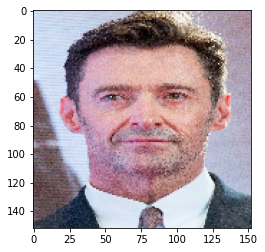

In [17]:
test_sample_image(classifier)

## MTCNN Facial Feature Detection

In [18]:
!pip install -q mtcnn

     |████████████████████████████████| 2.3MB 9.7MB/s 


In [19]:
from mtcnn import MTCNN
import cv2 as cv

img = cv.cvtColor(cv.imread(target_image_name), cv.COLOR_BGR2RGB)
mtdetector = MTCNN()
mtpreds = mtdetector.detect_faces(img)
mtpreds

[{'box': [254, 262, 792, 1056],
  'confidence': 0.9999310970306396,
  'keypoints': {'left_eye': (471, 699),
   'mouth_left': (507, 1068),
   'mouth_right': (828, 1062),
   'nose': (655, 896),
   'right_eye': (824, 688)}}]

In [20]:
## Utility - extract out into separate file
"""
Function to plot detection values around face
Plots bounding box as well as facial features
"""
def plot_detectionsmtcnn(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)
    


    print("Found %d faces" % len(detections))
        
    for i in range(len(detections)):
        box = detections[i]['box']
        print(box)
        rect = patches.Rectangle(box[0:2], box[2], box[3],
                                 linewidth=1, edgecolor="r", facecolor="none", 
                                 alpha=detections[i]['confidence'])
        ax.add_patch(rect)

        if with_keypoints:
            for pt in detections[i]['keypoints'].values():
                circle = patches.Circle(pt, radius=1, linewidth=1, 
                                        edgecolor="green", facecolor="green",
                                        alpha=detections[i]['confidence']
                                        )
                ax.add_patch(circle)
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.savefig('mtcnnoutput.png', bbox_inches='tight', pad_inches = 0)      
    plt.show()

Found 1 faces
[254, 262, 792, 1056]


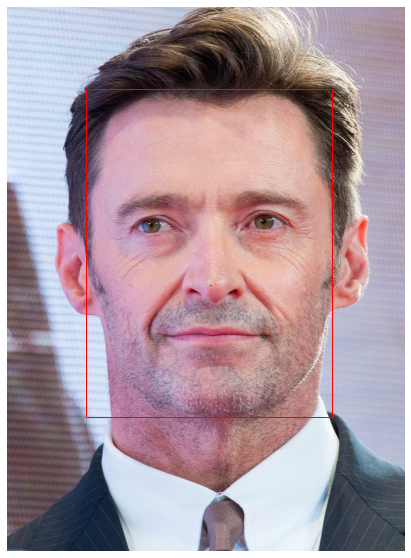

In [21]:
plot_detectionsmtcnn(img, mtpreds)

In [22]:
## Creates a mask for the image, extracts out facial feature predictions starting
## from `facial_feature_index`
def create_feature_mask_mtcnn(detections, img_shape, mask_pars=(0.04,0.06,0.04,0.07,0.06,0.03)):
  ## mask_pars=(eye_a, eye_b,  mouth_a, nose_a, nose_b, nose_y) is a tuple of hyperparameters.
  ## par_a and par_b are the prinicpal axes lengths in the y- and x-directions
  ## nose_y is the offset of the nose ellipse center in the y-direction
  mask = np.ones(shape=img_shape)
  eye_a, eye_b, mouth_a, nose_a, nose_b, nose_y = [x * img_shape[0] for x in mask_pars]
    
  for i in range(len(detections)):
    keypoints = detections[i]['keypoints']
    mouth_b = 1.1*(keypoints['mouth_right'][0] - keypoints['mouth_left'][0]) / 2
    for feat, pt in detections[i]['keypoints'].items():
      if feat != 'mouth_left':
        kp_x, kp_y = pt
        
        mask_x, mask_y = np.ogrid[-kp_y:img_shape[0]-kp_y, -kp_x:img_shape[1]-kp_x]
        if feat == 'left_eye' or feat == 'right_eye':
          kernel_mask = mask_x**2 / eye_a**2 + mask_y**2 / eye_b**2 <= 1
        if feat == 'mouth_right':
          kernel_mask = mask_x**2 / mouth_a**2 + (mask_y + mouth_b)**2 / mouth_b**2 <= 1
        if feat == 'nose':
          kernel_mask = (mask_x + nose_y)**2 / nose_a**2 + mask_y**2 / nose_b**2 <= 1
 #       kernel_mask = mask_x**2 + mask_y**2 <= mask_width ## Draw circle
        

        mask[kernel_mask] = 8e-1

  return mask

In [23]:
image_path = target_image_name
frame = cv.imread(target_image_name)
mask = create_feature_mask_mtcnn(mtpreds, frame.shape)
mask = mask.astype(np.float32)
mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
mask = mask/255.0

Found 1 faces
[254, 262, 792, 1056]


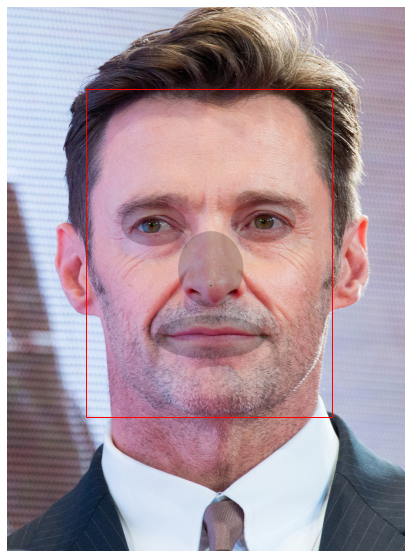

In [24]:
plot_detectionsmtcnn(img*mask, mtpreds)

In [25]:
## Function to apply mask to an adversarial image.
## Takes a hyper parameter of the mask width
def apply_mask_to_adv_noise_mtcnn(original_image, adv_image):
  ## Use facial feature extraction
  frame = cv.cvtColor(original_image, cv.COLOR_BGR2RGB)
  frame = cv.resize(frame, (152, 152))
  prediction = mtdetector.detect_faces(frame)

  ## Get mask
  mask = create_feature_mask_mtcnn(prediction, frame.shape)
  mask = mask.astype(np.float32)
  mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)

  ## calculate the diff between the adversarial image and the original image
  noise = adv_image - original_image.astype(np.float32)

  noise = cv.resize(noise, (152, 152))
  
  ## Limitation of blazeface is that it needs us to downsample the original image
  ## A bit more tweaking can work for higher resolution images
  original_resized_image = cv.resize(original_image, (152, 152))

  ## Apply mask and return
  return np.where(mask < 1, noise + original_resized_image, original_resized_image).astype(np.uint), noise ## send back noise for debugging

## Blazeface Facial Feature Detection
Using Blazeface to detect facial features

### Download blazeface pretrained model

In [26]:
## Fetch model file in pretrained model
## We don't need to do this outside collab
!wget https://raw.githubusercontent.com/hollance/BlazeFace-PyTorch/master/blazeface.py
!wget https://raw.githubusercontent.com/hollance/BlazeFace-PyTorch/master/anchors.npy
!wget https://raw.githubusercontent.com/hollance/BlazeFace-PyTorch/master/blazeface.pth

--2020-06-17 06:33:39--  https://raw.githubusercontent.com/hollance/BlazeFace-PyTorch/master/blazeface.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15555 (15K) [text/plain]
Saving to: ‘blazeface.py’

blazeface.py        100%[===================>]  15.19K  --.-KB/s    in 0.004s  

2020-06-17 06:33:40 (4.15 MB/s) - ‘blazeface.py’ saved [15555/15555]

--2020-06-17 06:33:41--  https://raw.githubusercontent.com/hollance/BlazeFace-PyTorch/master/anchors.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28800 (28K) [application/octet-strea

### Load pretrained blazeface

In [27]:
## interop all the way. Current attack uses Keras but our facial feature detection model is in Pytorch.
## Code adapted from https://www.kaggle.com/humananalog/inference-demo
from blazeface import BlazeFace
face_detector = BlazeFace().to(device)
face_detector.load_weights("./blazeface.pth")
face_detector.load_anchors("./anchors.npy")
_ = face_detector.train(False) ## Freeze weights

In [28]:
## Utility - extract out into separate file
"""
Function to plot detection values around face
Plots bounding box as well as facial features
"""
def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)
    
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])
        
    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none", 
                                 alpha=detections[i, 16])
        ax.add_patch(rect)

        if with_keypoints:
            for k in range(6):
                kp_x = detections[i, 4 + k*2    ] * img.shape[1]
                kp_y = detections[i, 4 + k*2 + 1] * img.shape[0]
                circle = patches.Circle((kp_x, kp_y), radius=1, linewidth=1, 
                                        edgecolor="green", facecolor="green", 
                                        alpha=detections[i, 16], fill=True)
                ax.add_patch(circle)
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.savefig('blazefaceoutput.png', bbox_inches='tight', pad_inches = 0)   
    plt.show()

In [29]:
image_path = target_image_name

In [30]:
frame = cv.imread(image_path)
frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
frame = cv.resize(frame, (128, 128))
prediction = face_detector.predict_on_image(frame)
prediction

tensor([[0.2707, 0.2441, 0.8149, 0.7884, 0.3849, 0.4053, 0.6489, 0.4028, 0.5172,
         0.5165, 0.5133, 0.6526, 0.2451, 0.4662, 0.7785, 0.4645, 0.9453]],
       device='cuda:0')

Found 1 faces


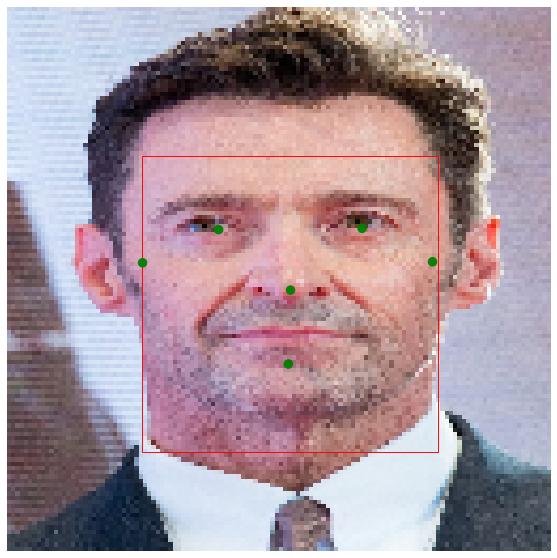

In [31]:
plot_detections(frame, prediction)

We'll now take each facial feature, create a filter around the features to create a mask
The mask is then used to fine tune the adversarial attacks to the facial features

In [32]:
## Creates a mask for the image, extracts out facial feature predictions starting
## from `facial_feature_index`
def create_feature_mask(detections, img_size, mask_width=7): # default to 4 because it's average size
  ## mask_width is a hyperparameter that will impact the effect of the attack
  ## too small a width won't work because the convnet filters can skip the perturbation
  ## this will intrinsically depend a lot on the filter size for the convnet in the facial detection model
  mask = np.ones(shape=(img_size, img_size))
  if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

  if detections.ndim == 1:
      detections = np.expand_dims(detections, axis=0)
  
  for i in range(detections.shape[0]):
    for k in range(6):
        kp_x = detections[i, 4 + k*2    ] * img_size
        kp_y = detections[i, 4 + k*2 + 1] * img_size
        
        mask_x, mask_y = np.ogrid[-kp_y:img_size-kp_y, -kp_x:img_size-kp_x]
        kernel_mask = mask_x**2 + mask_y**2 <= mask_width ## Draw circle
        

        mask[kernel_mask] = 8e-1

  return mask

In [33]:
mask = create_feature_mask(prediction, frame.shape[0], mask_width=30)
mask = mask.astype(np.float32)
mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
mask = mask/255.0

Found 1 faces


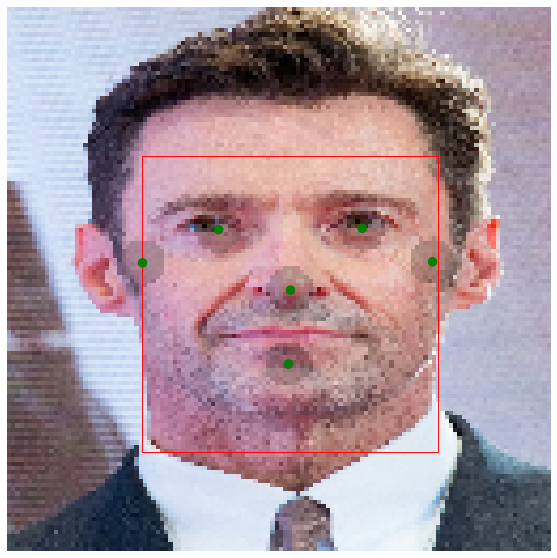

In [34]:
plot_detections(frame*mask, prediction)

## Adversarial Masking 

Adversarial image at step 0. L-inf error 50.0 and class label 4884.  Time Taken: 58


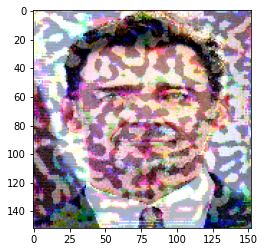

API response:valentino rossi


In [36]:
## Now that we have the mask let's apply the adversarial peturbations against this mask.
## Using deepface as a proxy model to attack
attack = FastGradientMethod(estimator=classifier, eps=50, norm=np.inf)
iter_step = 10
x_adv = None
for i in range(1):
  
    start = time.time()
    x_adv = attack.generate(x=np.array([target_image]), x_adv_init=x_adv, resume=True)
    end = time.time()

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L-inf error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image, [-1]), ord=np.inf),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]), " Time Taken: %d" % (end-start))
    plt.imshow(x_adv[0].astype(np.uint))

    fig1 = plt.gcf()
    plt.show()

    filename = 'adv' + str(i) + '.jpg'

    fig1.savefig(filename)

    model = app.models.get('celeb-v1.3')
    response = model.predict_by_filename(filename)
    try:
      name = response['outputs'][0]['data']['regions'][0]['data']['concepts'][0]['name']
      print("API response:" + name)
      ## early stop
      if name == 'lesley nicol':
        break
    except Exception:
      print("API Fooled")
    attack.max_iter = iter_step

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


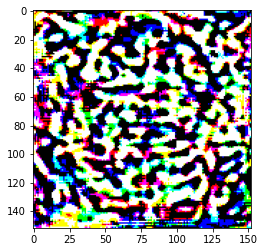

In [37]:
noise = x_adv[0] - target_image.astype(np.float32)
plt.imshow(noise)

In [38]:
noise_copy = noise.copy()
noise_copy = cv.resize(noise_copy, (128, 128))
mask = create_feature_mask(prediction, frame.shape[0])
mask = mask.astype(np.float32)
mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
copy_image = cv.resize(target_image, (128, 128))

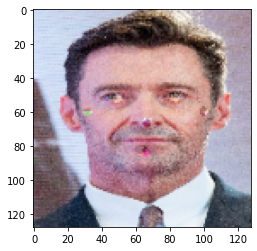

In [39]:
## let's apply the mask to image for blazeface
plt.imshow(np.where(mask < 1, noise_copy + copy_image, copy_image).astype(np.uint))

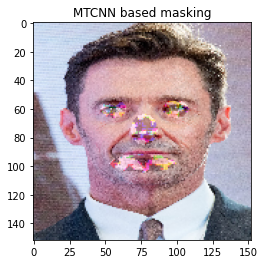

In [40]:
##mtcnn
masked, noise = apply_mask_to_adv_noise_mtcnn(target_image, x_adv[0].astype(np.uint))
plt.imshow(masked)
plt.title('MTCNN based masking');

In [41]:
## Function to apply mask to an adversarial image.
## Takes a hyper parameter of the mask width
def apply_mask_to_adv_noise(original_image, adv_image, mask_width=7):
  ## Use facial feature extraction
  frame = cv.cvtColor(original_image, cv.COLOR_BGR2RGB)
  frame = cv.resize(frame, (128, 128))
  prediction = face_detector.predict_on_image(frame)

  ## Get mask
  mask = create_feature_mask(prediction, frame.shape[0], mask_width)
  mask = mask.astype(np.float32)
  mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)

  ## calculate the diff between the adversarial image and the original image
  noise = adv_image - original_image.astype(np.float32)

  noise = cv.resize(noise, (128, 128))
  
  ## Limitation of blazeface is that it needs us to downsample the original image
  ## A bit more tweaking can work for higher resolution images
  original_resized_image = cv.resize(original_image, (128, 128))

  ## Apply mask and return
  return np.where(mask < 1, noise + original_resized_image, original_resized_image).astype(np.uint), noise ## send back noise for debugging

In [45]:
## Let's run this through the FastGradientMethod Attack

def run_fgsm_attacks(
    classifier, 
    target_image, 
    eps_range=list(range(50, 150, 20)), 
    mask_width=20, 
    masked=True, 
    history=None, ## Track changes and metrics
    ground_label='hugh jackman',
    img_show = True,
    debug=True,
    feature_extractor='blazeface',
    iter_step = 5):
  
  if history is None:
    history = dict()

  for eps in eps_range:
    attack = FastGradientMethod(estimator=classifier, eps=eps)
    x_adv = None
    for i in range(iter_step):
        try:

          start = time.time()
          x_adv = attack.generate(x=np.array([target_image]), x_adv_init=x_adv, resume=True)
          end = time.time()
          
          ### Apply mask
          adv_image = x_adv[0].astype(np.uint)
          print(adv_image.shape)
          target_image_copy = target_image.copy()
          if masked:
            if feature_extractor == 'blazeface':
              adv_image, _ = apply_mask_to_adv_noise(target_image, adv_image, mask_width=mask_width)
              target_image_copy = cv.resize(target_image_copy, (128, 128))

            else:
              adv_image, _ = apply_mask_to_adv_noise_mtcnn(target_image, adv_image)
              target_image_copy = cv.resize(target_image_copy, (152, 152))


          norm = np.linalg.norm(np.reshape(adv_image - target_image_copy, [-1]), ord=np.inf)

          if norm not in history.keys():
            history[norm] = 0 ## Store correct predictions

          if debug:
            print(
                f"Adversarial image at step {(i * iter_step)} \n L-inf error {norm} Time Taken: {end-start}")
          
          filename = f'masked_adv_{i}_{eps}.jpg'

          celeb_save_path = f'/content/data/celebatest_adv/{"-".join(ground_label.split(" "))}'

          if not os.path.exists(celeb_save_path):
            os.mkdir(celeb_save_path)
          
          if img_show:
            plt.imshow(adv_image)

            fig1 = plt.gcf()
            plt.show()
            fig1.savefig(f'{celeb_save_path}/{filename}')
          else:
            image.save_img(f'{celeb_save_path}/{filename}', adv_image)

          model = app.models.get('celeb-v1.3')
          response = model.predict_by_filename(f'{celeb_save_path}/{filename}')
          
          name = response['outputs'][0]['data']['regions'][0]['data']['concepts'][0]['name']
          if debug:
            print("API response:" + name)
          
          if name == ground_label:
            history[norm] += 1
            
        except Exception as e:
          print("Error:", e)
        attack.max_iter = iter_step

  return history

In [46]:
target_image_name = '/content/celebrity_image.jpg' # upload any two images, target_image_name has to be a celebrity
target_image = image.img_to_array(image.load_img(target_image_name, target_size=(152, 152)))

(152, 152, 3)
Adversarial image at step 0 
 L-inf error 10.9990234375 Time Taken: 0.292682409286499


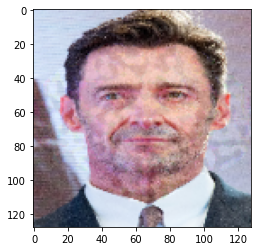

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 5 
 L-inf error 10.9990234375 Time Taken: 0.399066686630249


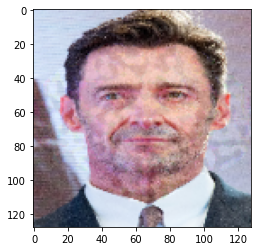

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 10 
 L-inf error 10.9990234375 Time Taken: 0.3985433578491211


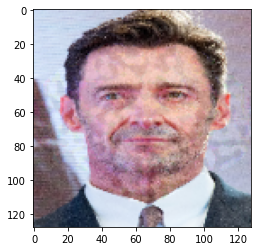

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 15 
 L-inf error 10.9990234375 Time Taken: 0.2801234722137451


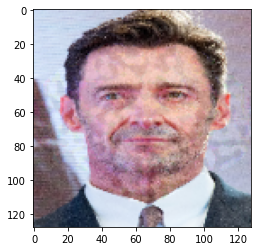

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 20 
 L-inf error 10.9990234375 Time Taken: 0.3266794681549072


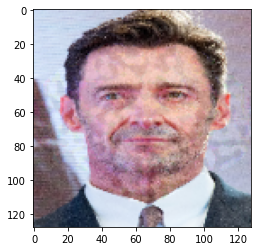

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 0 
 L-inf error 11.9990234375 Time Taken: 0.3350977897644043


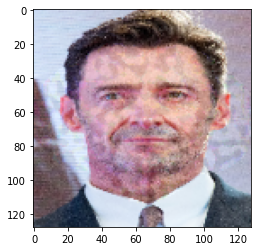

API response:hugh jackman
(152, 152, 3)
Adversarial image at step 5 
 L-inf error 11.9990234375 Time Taken: 0.2858603000640869


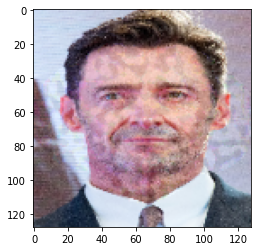

API response:hugh jackman
(152, 152, 3)
Adversarial image at step 10 
 L-inf error 11.9990234375 Time Taken: 0.28899383544921875


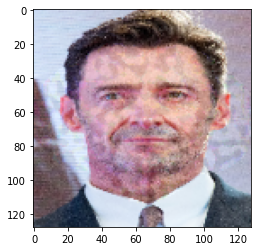

API response:hugh jackman
(152, 152, 3)
Adversarial image at step 15 
 L-inf error 11.9990234375 Time Taken: 0.4134104251861572


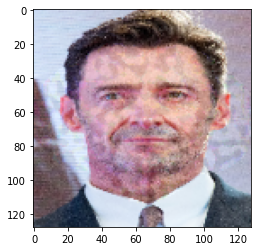

API response:hugh jackman
(152, 152, 3)
Adversarial image at step 20 
 L-inf error 11.9990234375 Time Taken: 0.29567861557006836


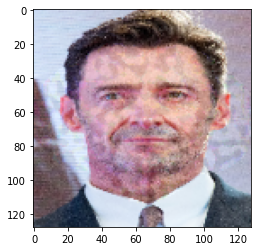

API response:hugh jackman
(152, 152, 3)
Adversarial image at step 0 
 L-inf error 12.9990234375 Time Taken: 0.36395764350891113


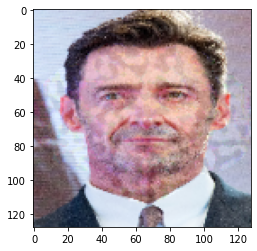

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 5 
 L-inf error 12.9990234375 Time Taken: 0.37792491912841797


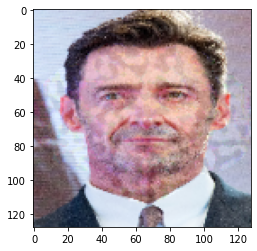

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 10 
 L-inf error 12.9990234375 Time Taken: 0.39766788482666016


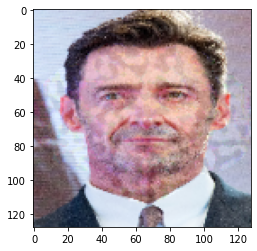

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 15 
 L-inf error 12.9990234375 Time Taken: 0.2807486057281494


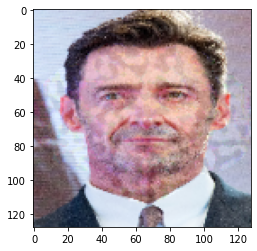

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 20 
 L-inf error 12.9990234375 Time Taken: 0.28098630905151367


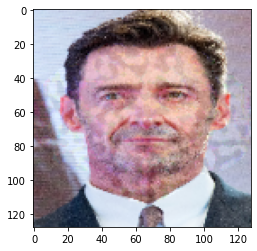

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 0 
 L-inf error 13.9990234375 Time Taken: 0.2830798625946045


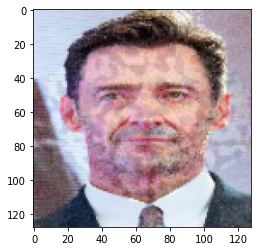

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 5 
 L-inf error 13.9990234375 Time Taken: 0.3197495937347412


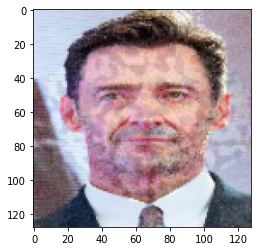

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 10 
 L-inf error 13.9990234375 Time Taken: 0.3668825626373291


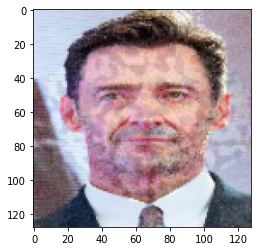

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 15 
 L-inf error 13.9990234375 Time Taken: 0.3758232593536377


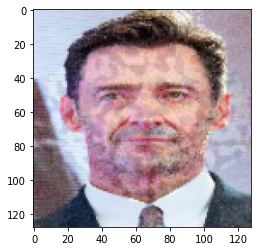

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 20 
 L-inf error 13.9990234375 Time Taken: 0.29508543014526367


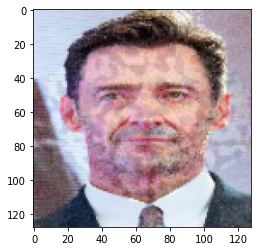

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 0 
 L-inf error 14.9990234375 Time Taken: 0.2905850410461426


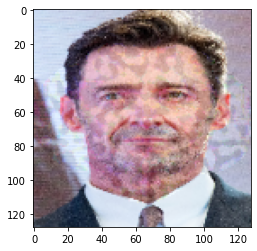

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 5 
 L-inf error 14.9990234375 Time Taken: 0.34319186210632324


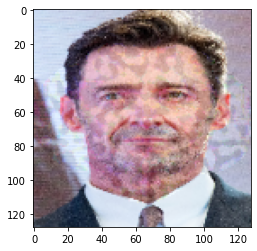

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 10 
 L-inf error 14.9990234375 Time Taken: 0.29773521423339844


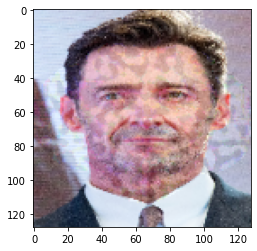

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 15 
 L-inf error 14.9990234375 Time Taken: 0.28103065490722656


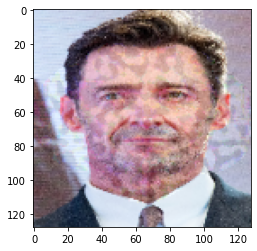

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 20 
 L-inf error 14.9990234375 Time Taken: 0.28241896629333496


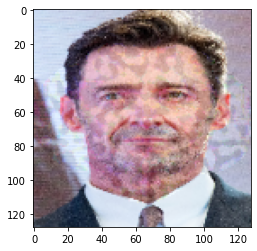

API response:justin timberlake
(152, 152, 3)
Adversarial image at step 0 
 L-inf error 10.0 Time Taken: 0.27916979789733887


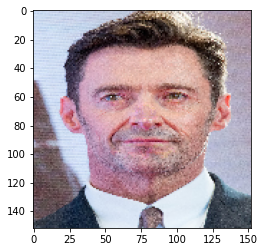

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 5 
 L-inf error 10.0 Time Taken: 0.4100663661956787


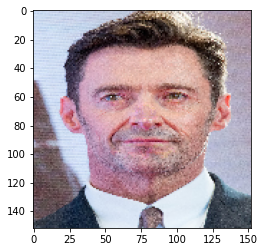

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 10 
 L-inf error 10.0 Time Taken: 0.2932753562927246


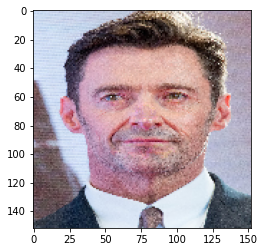

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 15 
 L-inf error 10.0 Time Taken: 0.38712310791015625


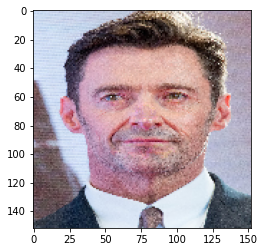

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 20 
 L-inf error 10.0 Time Taken: 0.28172731399536133


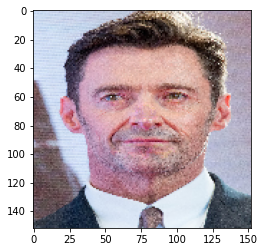

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 0 
 L-inf error 11.0 Time Taken: 0.2821784019470215


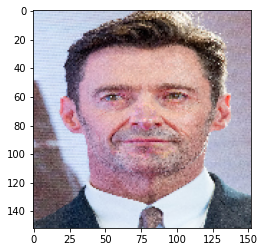

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 5 
 L-inf error 11.0 Time Taken: 0.28206491470336914


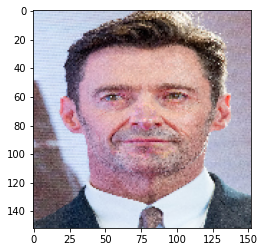

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 10 
 L-inf error 11.0 Time Taken: 0.28734922409057617


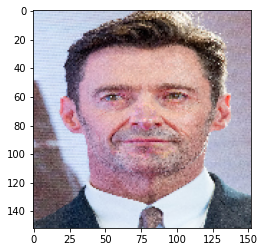

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 15 
 L-inf error 11.0 Time Taken: 0.4293689727783203


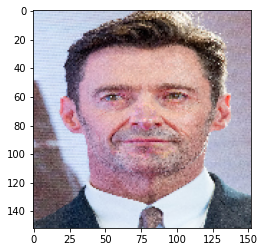

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 20 
 L-inf error 11.0 Time Taken: 0.2908663749694824


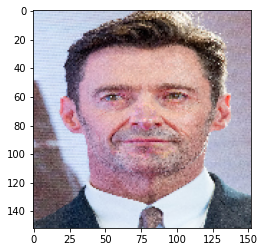

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 0 
 L-inf error 12.0 Time Taken: 0.2904016971588135


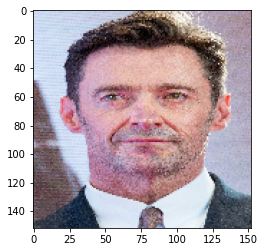

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 5 
 L-inf error 12.0 Time Taken: 0.29338836669921875


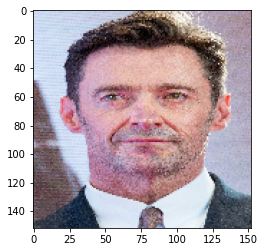

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 10 
 L-inf error 12.0 Time Taken: 0.2907435894012451


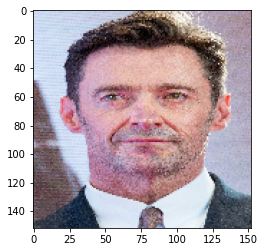

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 15 
 L-inf error 12.0 Time Taken: 0.29270267486572266


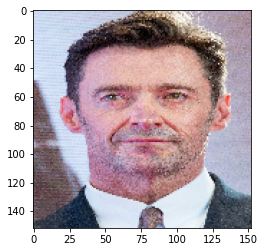

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 20 
 L-inf error 12.0 Time Taken: 0.41314053535461426


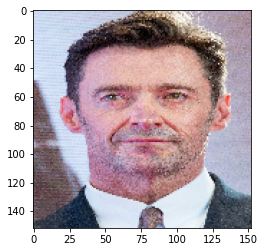

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 0 
 L-inf error 13.0 Time Taken: 0.2913937568664551


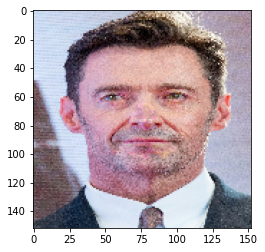

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 5 
 L-inf error 13.0 Time Taken: 0.4070162773132324


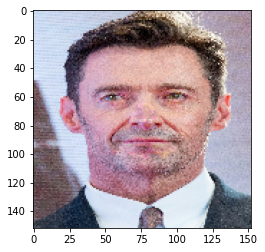

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 10 
 L-inf error 13.0 Time Taken: 0.30736684799194336


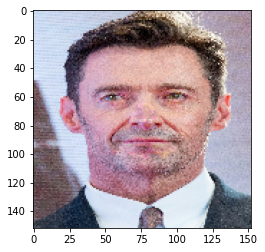

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 15 
 L-inf error 13.0 Time Taken: 0.2935030460357666


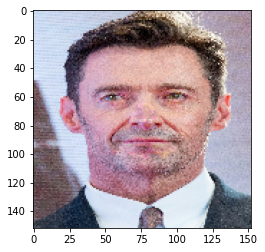

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 20 
 L-inf error 13.0 Time Taken: 0.3081955909729004


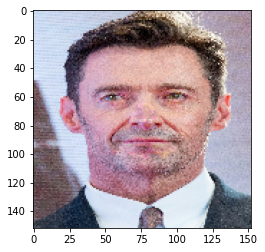

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 0 
 L-inf error 14.0 Time Taken: 0.28609609603881836


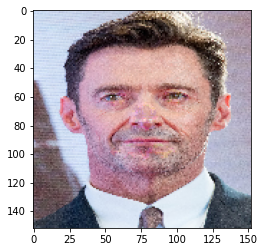

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 5 
 L-inf error 14.0 Time Taken: 0.29946422576904297


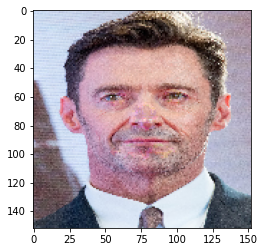

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 10 
 L-inf error 14.0 Time Taken: 0.3136100769042969


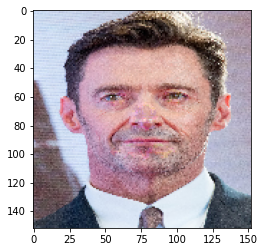

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 15 
 L-inf error 14.0 Time Taken: 0.2860281467437744


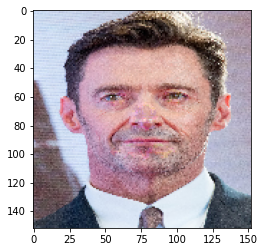

API response:rainn wilson
(152, 152, 3)
Adversarial image at step 20 
 L-inf error 14.0 Time Taken: 0.38672542572021484


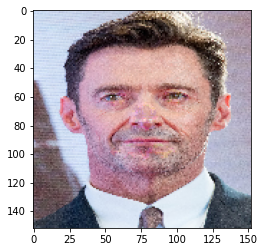

API response:rainn wilson


In [47]:
meta = dict()
for extractor in ['blazeface','mtcnn']:
  history=run_fgsm_attacks(
        classifier, 
        target_image, 
        eps_range=list(range(10, 15, 1)), 
        mask_width=1000, 
        masked=True,
        feature_extractor=extractor)
meta[extractor] = history

shape: (152, 152, 3)


{'outputs': [{'created_at': '2020-06-17T06:40:28.863238688Z',
   'data': {'regions': [{'data': {'concepts': [{'app_id': 'main',
         'id': 'ai_NPr29r5K',
         'name': 'rainn wilson',
         'value': 0.18782860040664673},
        {'app_id': 'main',
         'id': 'ai_nh0JWWSv',
         'name': 'hugh jackman',
         'value': 0.03784406930208206},
        {'app_id': 'main',
         'id': 'ai_NdGR05pj',
         'name': 'jack black',
         'value': 0.02122502215206623},
        {'app_id': 'main',
         'id': 'ai_B0jVr1fD',
         'name': 'jerry ferrara',
         'value': 0.014912249520421028},
        {'app_id': 'main',
         'id': 'ai_JzT5jBcG',
         'name': 'alden ehrenreich',
         'value': 0.0144511042162776},
        {'app_id': 'main',
         'id': 'ai_m9kB46nq',
         'name': 'justin timberlake',
         'value': 0.012976430356502533},
        {'app_id': 'main',
         'id': 'ai_jLlXMRjL',
         'name': 'steve zahn',
         'value': 0.00

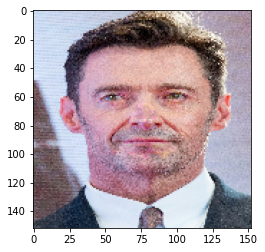

In [50]:

for i in range(20):
  x_adv = None
  attack = FastGradientMethod(estimator=classifier, eps=13)
  x_adv = attack.generate(x=np.array([target_image]), x_adv_init=x_adv, resume=True)

adv_image = x_adv[0].astype(np.uint)
adv_image, _ = apply_mask_to_adv_noise_mtcnn(target_image, adv_image)
plt.imshow(adv_image)
print("shape:", adv_image.shape)
plt.imshow(adv_image.astype('u1'))
plt.savefig('hugh_high13.png')

model = app.models.get('celeb-v1.3')
model.predict_by_filename(f'hugh_high13.png')


In [ ]:
## Compare this to a deepface proxy without a mask

non_maskhistory = run_fgsm_attacks(
    classifier, 
    target_image, 
    eps_range=list(range(5, 15, 1)), 
    mask_width=30,
    masked=False)

In [ ]:
meta['non_mask']= non_maskhistory

In [ ]:
df = pd.DataFrame(meta)
df = df.reset_index()
df = df.T
df

In [ ]:
## Clean up
df = df.sort_values(by='index', axis=1)
df

In [ ]:
df = df.fillna(method='ffill', axis=1)

In [ ]:
df.iloc[1:] = df.iloc[1:]/5.0

In [ ]:
fig = Go.Figure()
    
fig.add_trace(
    Go.Scatter(
        x=df.iloc[0],
        y=df.iloc[1],
        name='Single Image Blazeface radial Mask',
        mode='lines+markers',
        connectgaps=True
      )
)
fig.add_trace(
    Go.Scatter(
        x=df.iloc[0],
        y=df.iloc[2],
        name='Single Image MTCNN Elliptical Mask',
        mode='lines+markers',
        connectgaps=True
      )
)

fig.add_trace(         
    Go.Scatter(
        x=df.iloc[0],
        y=df.iloc[3],
        name='Single Image No Mask',
        mode='lines+markers',
        connectgaps=True
      )
)
fig.add_trace(
    Go.Scatter(
      x=[10.999]*6,
      y=list(range(-1, 3)),
      mode='lines',
      name='Fooling Benchmark Radial Mask'
    )
)
fig.add_trace(
    Go.Scatter(
      x=[10]*6,
      y=list(range(-1, 3)),
      mode='lines',
      name='Fooling Benchmark No Mask'
    )
)

fig.add_trace(
    Go.Scatter(
      x=[14.9990]*6,
      y=list(range(-1, 3)),
      mode='lines',
      name='Fooling Benchmark MTCNN Elliptical Mask'
    )
)

fig.update_layout(
    title="L-inf norm vs Accuracy",
    xaxis_title="L inf norm",
    yaxis_title="Accuracy",
)

fig.show()

## Calculate error rates with masked vs non masked attacks on multiple images

Note: We are limited by the number of api calls we can make to clarifai. Thus we are only testing 5 images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/data/CelebAMask-HQ.zip') as f:
  test_images = f.namelist()[:100] ## pick only 100 images
  for filename in test_images:
    _, ext = os.path.splitext(filename)
    if ext in ['.jpg']:
      f.extract(filename, path='/content/data/celebahq')
  f.close()

In [ ]:
# from DeepFace import create_deepface, get_weights
deepface = create_deepface()

weights = get_weights()
deepface.load_weights(weights)

## re-init classifier too wipe any state being stored in the library
classifier = KerasClassifier(clip_values=(0, 255), model=deepface, preprocessing=(mean_imagenet, 1))

In [ ]:
history = {
    'non_mask': [],
    'mask': []
}
dirname = '/content/data/celebahq/CelebAMask-HQ/CelebA-HQ-img'
train_len = 5 # modify this if needed

for filename in os.listdir(dirname)[:train_len]:
  file_path = f'{dirname}/{filename}'
  target_image = image.img_to_array(image.load_img(file_path, target_size=(152, 152)))
  
  try:
    model = app.models.get('celeb-v1.3')
    response = model.predict_by_filename(file_path)

    truth = response['outputs'][0]['data']['regions'][0]['data']['concepts'][0]['name']

    print(f'Ground truth: {truth}')

    ## Attack without mask
    print("Non-Masked Attacks")
    
    non_mask_history = run_fgsm_attacks(
        classifier, 
        target_image, 
        eps_range=list(range(5, 20, 2)), 
        mask_width=30, 
        masked=False, 
        debug=False,
        img_show=False,
        ground_label=truth)
    history['non_mask'].append(non_mask_history)
  except Exception as e:
    print(e)

In [ ]:
for filename in os.listdir(dirname)[:train_len]:
  file_path = f'{dirname}/{filename}'
  target_image = image.img_to_array(image.load_img(file_path, target_size=(152, 152)))
  
  try:
    model = app.models.get('celeb-v1.3')
    response = model.predict_by_filename(file_path)

    truth = response['outputs'][0]['data']['regions'][0]['data']['concepts'][0]['name']

    print(f'Ground truth: {truth}')

    ## Attack with mask
    print("Masked Attacks")
    mask_history = run_fgsm_attacks(
        classifier, 
        target_image, 
        eps_range=list(range(5, 40, 5)), 
        mask_width=30, 
        masked=True,
        img_show=False,
        debug=False,
        ground_label=truth)
    history['mask'].append(mask_history)
  except Exception as e:
    print(e)

In [ ]:
mask = pd.DataFrame(history['mask'])
non_mask = pd.DataFrame(history['non_mask'])

In [ ]:
## Plot L_inf v/s error rate
mask.fillna(40, inplace=True)
non_mask.fillna(40, inplace=True)

In [ ]:
cols = list(mask.columns)
cols.sort()
mask.columns = cols
non_mask.columns = cols

In [ ]:
fig = Go.Figure(
    data=[
          Go.Scatter(
            x=list(mask.columns),
            y=mask.sum()/(40*train_len),
            name='Masked'
          ),
          Go.Scatter(
            x=list(non_mask.columns),
            y=non_mask.sum()/(40*train_len),
            name='Non masked'
          )
    ]
  )
fig.update_layout(
    title="L-inf norm vs Accuracy over CelebHQ data",
    xaxis_title="L inf norm",
    yaxis_title="Accuracy",
)
fig.show()

In [ ]:
mask

In [ ]:
non_mask